In [4]:
#we start by importing all the necessary libraries

import os
import sys
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [5]:
#reding and analyzing the data 
df = pd.read_csv(filepath_or_buffer="../air-traffic-prediction/parkingLot.csv")
print(df.head())
print(df.shape)

  vehicle_no            timestamp  camera_id
0   MHUN7063  2024-09-12 05:00:00          1
1   MHYN4677  2024-09-12 05:00:00          1
2   MHEL6595  2024-09-12 05:00:00          1
3   MHNQ2590  2024-09-12 05:00:00          1
4   MHHA0518  2024-09-12 05:00:00          1
(106694, 3)


### Filtering the Data Based on the following parameters
- dropping all the NA values 
- removing duplicate values if any
- removing all the timestamps which happen after 12 am and before 5 am (as given the mall is closed in this time)
- removing if some vehichle number doesn't follow a given general vehichle regex


In [6]:
def valid_vehicle_no(vehicle_no):
    pattern = r'^[A-Z]{4}[0-9]{4}$'
    return bool(re.match(pattern=pattern, string=vehicle_no))

print(f"Shape Before Filtering : {df.shape}")

df = df.dropna()
df = df.sort_values(by='timestamp')
df = df.drop_duplicates()


df['timestamp'] = pd.to_datetime(df['timestamp'])
mask = ~((df['timestamp'].dt.hour > 0) & (df['timestamp'].dt.hour < 5))
df = df[mask]

df = df[df['vehicle_no'].apply(func=valid_vehicle_no)]

print(f"Shape After Filtering  : {df.shape}")

Shape Before Filtering : (106694, 3)
Shape After Filtering  : (105978, 3)


### Merging 

Now we merge the vehichles captured by the camera1 and canera2 into a complete database
identifying on each day when a vehicle entered the mall and exited the mall in the dataframe 
called merged_data, and assuring the following in the merged_data:

- A vehicles exit time > it's entry time
- A vehicle enters and exits the mall in the same day(to avoid huge outliers caused due to missing NA's having difference of multiple days    which does not make sense in a general sense in a real scenario )

In [7]:

camera_1 = df[df['camera_id'] == 1]
camera_2 = df[df['camera_id'] == 2]


merged_data = pd.merge(camera_1, camera_2, on='vehicle_no', suffixes=('_entry', '_exit'))

#convert 'timestamp_entry' and 'timestamp_exit' to datetime
merged_data['timestamp_entry'] = pd.to_datetime(merged_data['timestamp_entry'])
merged_data['timestamp_exit'] = pd.to_datetime(arg=merged_data['timestamp_exit'])

#ensure timestamps are on the same date by comparing just the date part
merged_data = merged_data[
    (merged_data['timestamp_entry'].dt.date == merged_data['timestamp_exit'].dt.date) &
    (merged_data['timestamp_entry'] <= merged_data['timestamp_exit'])
]

daily_counts = merged_data.groupby(merged_data['timestamp_entry'].dt.date)['vehicle_no'].nunique()

In [8]:

import warnings
warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, loc=(1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

### Analyzing
Now we analyze the data on multiple parameters:
- The Augmented Dickey–Fuller unit test examines if the time series is non-stationary
- The ACF and PACF values for different lags to examining the data and predict the Auto Regerssive and Moving average terms

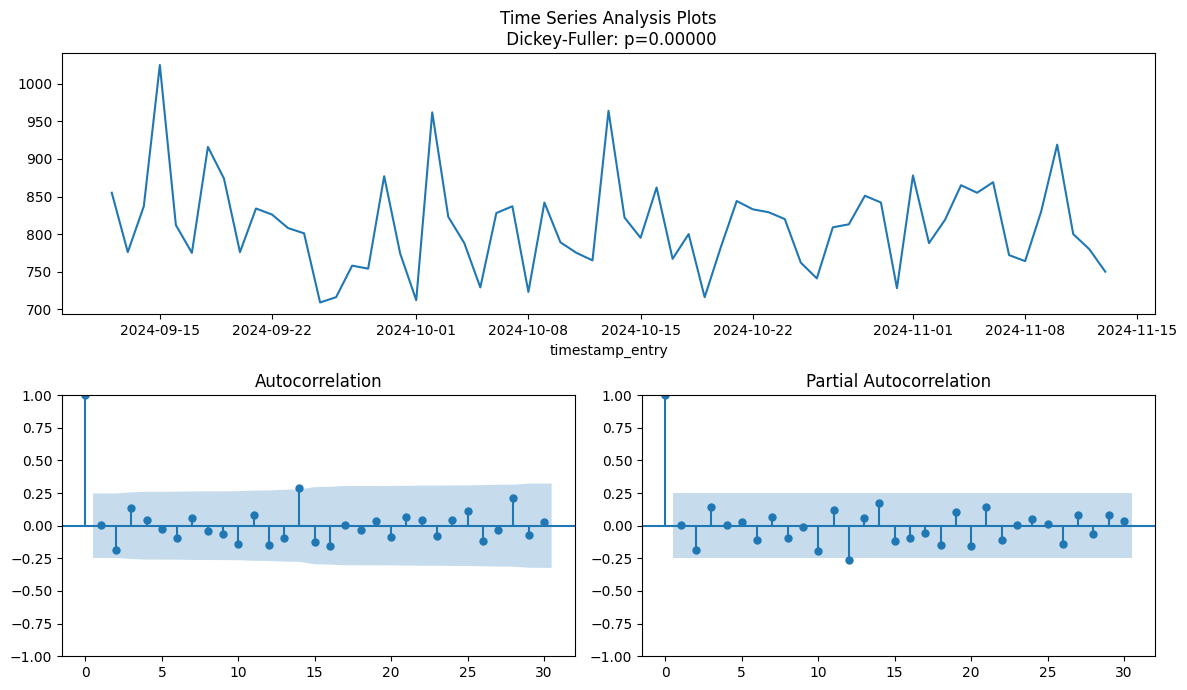

In [9]:
tsplot(daily_counts, lags = 30)

## Analysis
On analyzing the above data we see the p value = 0.000 ,
- indicating that the series is not non-stationary implying that it is stationary
- this happened for the series itself implying d = 0 , 
- also only a significant ACF and PACF value at lag 1 indicating that the p, q params are mostly 0 or either something small
- we notice slight bumps in PACF and ACF at around every 14th value indicating some small seasonality 

Thus, while training we will keep set **d = 0**, the AR term to be **0 < p <= 3** , the MA term to be **0 < q <= 3** , and the **seasonality = 14** days 


Also we forecast using another fixed ARIMA(0,0,0) with seasonality = 14 along with the trained autoARIMA

In [10]:
warnings.filterwarnings("ignore")

y = pd.DataFrame(data=daily_counts, index=pd.to_datetime(arg=daily_counts.index))

y_train, y_test = temporal_train_test_split(y, test_size=7)
y_train.index.freq = 'D'
y_test.index.freq = 'D'

#fitting the model using AUTO ARIMA
model = AutoARIMA( start_q = 0 , max_q = 3 ,d = 0 , start_P=0 , max_P=3 , sp=14)
model.fit(y_train)

y_pred = model.predict(fh=np.arange(1, 8))

#forecasting using fixed parameters for the SARIMAX model ARIMA(0,0,0) with a seasonality of 14 as inferreed from the various plots
sarimax_model = SARIMAX(endog=y_train, order=(0, 0,0), seasonal_order=(1, 1, 2, 14))
sarimax_result = sarimax_model.fit(disp=False)

y_pred_sarima = sarimax_result.forecast(steps=7)

In [11]:
def mean_absolute_scaled_error(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase

In [12]:

mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred)
mase_s = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred_sarima)
y_pred_sarima = sarimax_result.forecast(steps=7)


mape = mean_absolute_percentage_error(y_test, y_pred)
mape_s = mean_absolute_percentage_error(y_test, y_pred_sarima)


print(f"MASE uisng autoARIMA: {mase:.4f}")    
print(f"MAPE using autoARIMA: {mape * 100:.2f}%")  

print(f"MASE using SARIMAX: {mase_s:.4f}")    
print(f"MAPE using SARIMAX: {mape_s * 100:.2f}%")  

MASE uisng autoARIMA: 0.9947
MAPE using autoARIMA: 6.87%
MASE using SARIMAX: 0.8960
MAPE using SARIMAX: 6.09%


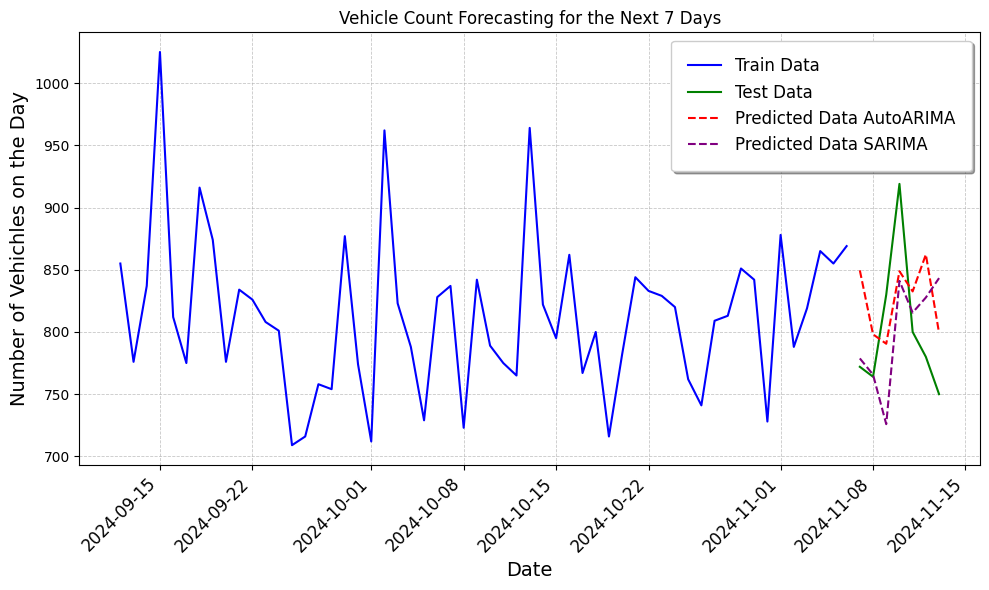

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Train Data", color='blue')
plt.plot(y_test.index, y_test, label="Test Data", color='green')

future_dates = pd.date_range(start=y.index[-8] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, y_pred, label="Predicted Data AutoARIMA", color='red', linestyle='--')
plt.plot(future_dates, y_pred_sarima, label="Predicted Data SARIMA", color='purple', linestyle='--')

plt.title('Vehicle Count Forecasting for the Next 7 Days')
plt.xlabel(xlabel='Date', fontsize=14)
plt.ylabel('Number of Vehichles on the Day', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.show()